# Validations Review

Additional supplementary figures for v2 of the manuscript

In [1]:
import_dl_modules = True

In [2]:
## Imports
# base python
from importlib import reload
import re
import itertools
import random
import os
from pathlib import Path
random.seed(1337)
import pickle
from decimal import Decimal
import collections

# numpy and similar
import numpy as np
np.random.seed(1337)
import pandas as pd
pd.options.mode.chained_assignment = None 
import scipy.stats as stats

# plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import plotnine

# Deep Learning related packages and scripts
if import_dl_modules:
    #os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Use gpu?
    import tensorflow as tf
    import keras
    from keras import backend as K
    from keras.models import load_model
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    # modelling and utility code
    import model
    import utils_data
    import utils

Using TensorFlow backend.


In [3]:
import matplotlib_config
matplotlib_config.paper_config()

In [4]:
if import_dl_modules:
    with open(Path("../Data/data_dict.pkl"), 'rb') as handle:
        data_dict = pickle.load(handle)
    for key in data_dict:
        print(key)
        print(len(data_dict[key]))

mpra
980244
snv
1584
ptr
11575
wilhelm
5293
andreev
8003
pcr3
7672
eichhorn
8956
doudna
25831
varlen_mpra
102214


# Perform predictions

In [5]:
if import_dl_modules:
    utr_model_50 = load_model("../Models/utr_model_50.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # Framepool50
    utr_model = load_model("../Models/utr_model_100_residual.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # Framepool100
    library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})
    utr_model_combined = load_model("../Models/utr_model_combined_residual.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # FramepoolCombined
    paper_model_orig = load_model("../Models/main_MRL_model.hdf5") # Optimus50
    paper_model = load_model("../Models/retrained_main_MRL_model.hdf5") 
    paper_model2 = load_model("../Models/Varying_length_25to100_model.hdf5") # Optimus100
    modelname_dict = {"Optimus50": paper_model_orig, "Framepool50": utr_model_50,
                      "Optimus100": paper_model2, "Framepool100": utr_model, "FramepoolCombined": utr_model_combined}

Instructions for updating:
Colocations handled automatically by placer.


2021-02-08 12:33:49,818 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2021-02-08 12:33:50,005 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


2021-02-08 12:34:02,059 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2021-02-08 12:34:02,203 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [5]:
# Code to run a prediction on MPRA data
def predict_on_MPRA(model, data_dict, varlen = False, library = "egfp_unmod_1", min_len = None,
                    extra_encoding_fn=[], postproc_mean=5.58621521, postproc_sd=1.34657403):
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    if varlen:
        data_df = data_dict["varlen_mpra"].copy()
    else:
        data_df = data_dict["mpra"].copy()
    df = data_df[(data_df.library == library) & (data_df.set == "test")]
    generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
    predict = model.predict_generator(generator, verbose=0)
    if min_len is not None:
        predict = predict * postproc_sd + postproc_mean
    df["pred"] = predict.reshape(-1)
    df = df.rename(columns={"pred": "Predicted MRL", "rl": "Observed MRL"})
    return df

# build dataframe
def build_mpra_prediction(human=False):
    concat_df = pd.DataFrame(columns=['Predicted MRL', 'Observed MRL', 'model', 'data', 'R'])
    for modelname in ["Optimus50", "Framepool50", "Optimus100", "Framepool100", "FramepoolCombined"]:
        predmodel = modelname_dict[modelname]
        min_len = None
        if modelname == "Optimus50":
            min_len = 50
        if modelname == "Optimus100":
            min_len = 100
        extra_encoding_function = []
        if modelname == "FramepoolCombined":
            extra_encoding_function = [library_fn]
        data_types = [("Fixed length (50 nt) MPRA", "egfp_unmod_1", False), ("Variable length (25-100 nt) MPRA", "random", True)]
        if human:
            data_types = [("Fixed length (50 nt) MPRA", "human", False), ("Variable length (25-100 nt) MPRA", "human", True)]
        for data in data_types:
            varlen = data[2]
            dataname = data[0]
            library = data[1]
            pred_df = predict_on_MPRA(predmodel, data_dict, varlen = varlen, library = library, min_len = min_len,
                                     extra_encoding_fn = extra_encoding_function)
            pred_df = pred_df[["Predicted MRL", "Observed MRL"]]
            #print((modelname, dataname))
            pred_df["model"] = modelname
            pred_df["data"] = dataname
            pred_df["R"] = round(stats.pearsonr(pred_df["Predicted MRL"], pred_df["Observed MRL"])[0], 3)
            concat_df = pd.concat([concat_df, pred_df])
    return concat_df

In [ ]:
# If predictions have not yet been made, make them and save
if not os.path.exists(Path("../Data/Predictions/mpra_random_prediction.csv")):
    mpra_pred_df = build_mpra_prediction()
    mpra_pred_df.to_csv(Path("../Data/Predictions/mpra_random_prediction.csv"))
if not os.path.exists(Path("../Data/Predictions/mpra_human_prediction.csv")):
    mpra_pred_df_human = build_mpra_prediction(human=True)
    mpra_pred_df_human.to_csv(Path("../Data/Predictions/mpra_human_prediction.csv"))

In [7]:
# Load predictions
mpra_pred_df = pd.read_csv(Path("../Data/Predictions/mpra_random_prediction.csv"))
mpra_pred_df_human = pd.read_csv(Path("../Data/Predictions/mpra_human_prediction.csv"))

In [8]:
mpra_pred_df[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,Optimus50,Fixed length (50 nt) MPRA,0.966
20000,Optimus50,Variable length (25-100 nt) MPRA,0.743
27600,Framepool50,Fixed length (50 nt) MPRA,0.964
47600,Framepool50,Variable length (25-100 nt) MPRA,0.901
55200,Optimus100,Fixed length (50 nt) MPRA,0.938
75200,Optimus100,Variable length (25-100 nt) MPRA,0.915
82800,Framepool100,Fixed length (50 nt) MPRA,0.929
102800,Framepool100,Variable length (25-100 nt) MPRA,0.903
110400,FramepoolCombined,Fixed length (50 nt) MPRA,0.954
130400,FramepoolCombined,Variable length (25-100 nt) MPRA,0.914


# Additional Plots for Framepool100 and FramepoolCombined

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


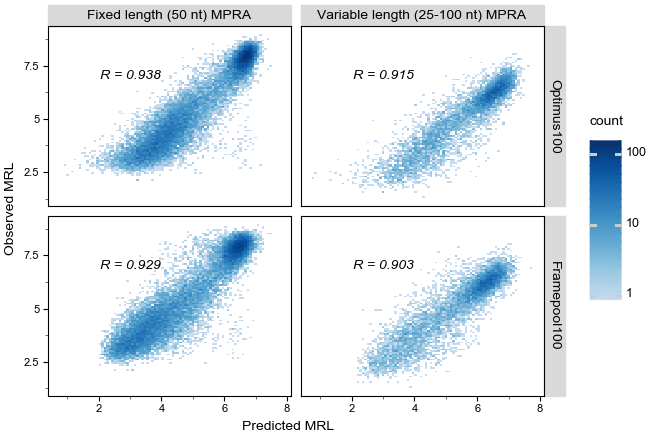

<ggplot: (2984905368040)>

In [9]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["Optimus100","Framepool100"])]

# Fix labels
plotlabel_dict = {"A": "Optimus100", "B": "Framepool100", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 3, y = 7, label = "R"), fontstyle = "italic")
 + plotnine.theme_matplotlib())
p

In [10]:
p.save("../Graphics/" + "FrameVOptimus100" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/FrameVOptimus100.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcpar

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


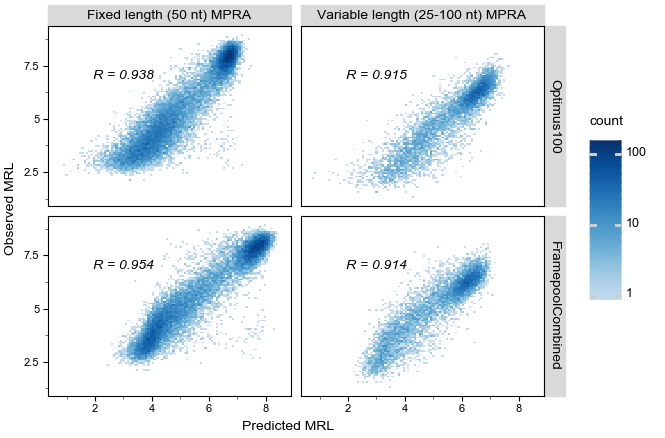

<ggplot: (-9223369051932758023)>

In [11]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["Optimus100","FramepoolCombined"])]

# Fix labels
plotlabel_dict = {"A": "Optimus100", "B": "FramepoolCombined", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(round(x,3)))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 3, y = 7, label = "R"), fontstyle = "italic")
 + plotnine.theme_matplotlib())
p

In [13]:
p.save("../Graphics/" + "FrameVOptimusCombined" + ".svg", width=7.0, height=7.0*0.66)

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.62 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/FrameVOptimusCombined.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="

# uTIS strength

In [6]:
noderer_df_aug = pd.read_csv(Path("../Data/TIS/tis_efficiencies_aug.tsv"), sep='\t')
noderer_df_aug = noderer_df_aug.rename(index=str, columns={"sequence":"TIS_Sequence", "efficiency":"TIS_Efficiency"})
noderer_df_nonaug = pd.read_csv(Path("../Data/TIS/tis_efficiencies_nonaug.tsv"), sep='\t')
# Recode U to T
noderer_df_aug["TIS_Sequence"] = noderer_df_aug["TIS_Sequence"].str.replace("U", "T")
noderer_df_nonaug["TIS_Sequence"] = noderer_df_nonaug["TIS_Sequence"].str.replace("U", "T")
# Prepare AUG data for injection
noderer_df_aug["TIS_Sequence_AGG"] = [seq[:7] + "G" + seq[8:] for seq in noderer_df_aug["TIS_Sequence"]]
bad_end = noderer_df_aug["TIS_Sequence"].str.endswith("AT")
double_trouble = noderer_df_aug["TIS_Sequence_AGG"].str.contains("ATG")
noderer_df_aug_sub = noderer_df_aug[(~bad_end) & (~double_trouble)]
noderer_df_aug = noderer_df_aug_sub
# Prepare nonaug data for injection
# Remove AUG creating motifs
atg_trouble = noderer_df_nonaug["TIS_Sequence"].str.contains("ATG")
noderer_df_nonaug = noderer_df_nonaug[~atg_trouble]

In [7]:
# select which model to use
model_to_apply = utr_model_50
# prepare run
extra_encoding_fn = []
one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
one_hot_fn_active = utils_data.OneHotEncoder("snv")
samples = 100
diffs = []
# run
for i in range(samples):
    prefix = ''.join(random.choices(["C","T","G"], k=9)) # fast way to get AUG free seq 
    suffix = ''.join(random.choices(["C","T","G"], k=9)) # fast way to get AUG free seq
    noderer_df_aug["snv"] = [prefix + seq + suffix for seq in
                                            noderer_df_aug["TIS_Sequence"]]
    noderer_df_aug["wt"] = [prefix + seq + suffix for seq in
                                        noderer_df_aug["TIS_Sequence_AGG"]]
    gen_wt = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                     shuffle=False)
    predict_wt_only = model_to_apply.predict_generator(gen_wt, verbose=0)
    gen_snv = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                      shuffle=False)
    predict_snv_only = model_to_apply.predict_generator(gen_snv, verbose=0)
    log_pred_diff_only = np.log2(predict_snv_only/predict_wt_only)
    diffs.append(log_pred_diff_only)
diffs = sum(diffs)/len(diffs)
noderer_df_aug["Predicted log2 Fold Change"] = diffs.reshape(-1)
noderer_df_aug["PredFC"] = (2 ** noderer_df_aug["Predicted log2 Fold Change"])*100 - 100
noderer_df_aug["codon"] = "AUG"
noderer_df_aug_reduced = noderer_df_aug[['TIS_Sequence', 'TIS_Efficiency', "PredFC", "codon"]]
print(stats.pearsonr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))
print(stats.spearmanr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))
noderer_df_aug_reduced.to_csv(Path("../Data/Predictions/aug_50_predictions.csv"))

(-0.7754959499158632, 0.0)
SpearmanrResult(correlation=-0.7521988890466702, pvalue=0.0)


In [8]:
# make random seq without AUG
def random_seq_noaug(exclude_motifs=["CTG","GTG"]):
    seq = ''.join(random.choices(["A","C","T","G"], k=9))
    # (try to) clean out unwanted motifs that could eat results
    for motif in exclude_motifs:
        motifs_present = [m.start() for m in re.finditer(motif, seq)]
        for idx in motifs_present:
            seq = seq[:idx] + ''.join(random.choices(["A","C","T","G"], k=2)) + seq[idx+3:]
    # (surely) clean out atg, since they dominate everything
    atg_present = [m.start() for m in re.finditer('ATG', seq)]
    for idx in atg_present:
        seq = seq[:idx] + "C" + ''.join(random.choices(["C","T","G"], k=2)) + seq[idx+3:]
    return seq
    
# Predict
# Select model and prepare run
extra_encoding_fn = []
model_to_apply = utr_model_50
nonaug_dict = {key:noderer_df_nonaug[noderer_df_nonaug["TIS_Sequence"].str[-4:-1] == key] for key in
               set(noderer_df_nonaug["TIS_Sequence"].str[-4:-1])}
key_to_inactive = {'CTG':"CTT", 'ACG':"ACT", 'AAG':"AAC", 'GTG':"GTT", 
                   'ATA':"ACT", 'AGG':"AGT", 'ATT':"GTT", 'ATC':"GTC", 
                   'TTG':"TTT"}
one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
one_hot_fn_active = utils_data.OneHotEncoder("snv")
samples = 100
# Run
for key in nonaug_dict.keys():
    nonaug_dict[key]["TIS_inactive"] = [seq[:-4] + key_to_inactive[key] + seq[-1] for seq in
                                        nonaug_dict[key]["TIS_Sequence"]]
    diff_list = []
    for i in range(samples):
        prefix = random_seq_noaug()
        suffix = random_seq_noaug()
        nonaug_dict[key]["snv"] = [prefix + seq + suffix for seq in
                                            nonaug_dict[key]["TIS_Sequence"]]
        nonaug_dict[key]["wt"] = [prefix + seq + suffix for seq in
                                        nonaug_dict[key]["TIS_inactive"]]
        gen_wt = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                         shuffle=False)
        predict_wt_nonaug = model_to_apply.predict_generator(gen_wt, verbose=0)
        gen_snv = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                          shuffle=False)
        predict_snv_nonaug = model_to_apply.predict_generator(gen_snv, verbose=0)
        log_pred_diff_nonaug = np.log2(predict_snv_nonaug/predict_wt_nonaug)
        diff_list.append(log_pred_diff_nonaug)
    print("iteration done")
    diffs = sum(diff_list)/len(diff_list)    
    nonaug_dict[key]["Predicted log2 Fold Change"] = diffs
# Combine
df_list = []
for key in nonaug_dict.keys():
    if key not in ["CTG", "GTG"]:
        continue
    nonaug_dict[key]["codon"] = key.replace("T","U")
    nonaug_dict[key]["PredFC"] = (2 ** nonaug_dict[key]["Predicted log2 Fold Change"])*100 - 100
    df_list.append(nonaug_dict[key][['TIS_Sequence', 'TIS_Efficiency', "PredFC", "codon"]])
combined_nonaug = pd.concat(df_list)
# Save
combined_nonaug.to_csv(Path("../Data/Predictions/nonaug_50_predictions.csv"))

iteration done
iteration done
iteration done
iteration done
iteration done
iteration done
iteration done
iteration done
iteration done


In [9]:
# Read AUG data
noderer_df_aug_reduced = pd.read_csv(Path("../Data/Predictions/aug_50_predictions.csv"))
# Read Non aug data
combined_nonaug = pd.read_csv(Path("../Data/Predictions/nonaug_50_predictions.csv"))

# combine
combined_codon_df = pd.concat([noderer_df_aug_reduced, combined_nonaug])
# copy
all_df = combined_codon_df.copy()
allname = "Combined"
all_df["codon"] = allname
# combine with copy
combined_all = pd.concat([all_df, combined_codon_df[combined_codon_df.codon.isin(["AUG", "CUG", "GUG"])]])


# compute correlations
codon_keys = [allname, "AUG", "CUG", "GUG"]
r_list = []
for key in codon_keys:
    subcodon_df = combined_all[combined_all.codon == key]
    r = "R = " + str(round(stats.pearsonr(subcodon_df["TIS_Efficiency"], subcodon_df["PredFC"])[0], 3))
    r_list.append(r)
r_dat = pd.DataFrame({"codon":codon_keys,"r":r_list})
r_dat

,codon,r
0,Combined,R = -0.814
1,AUG,R = -0.784
2,CUG,R = -0.769
3,GUG,R = -0.375


/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  r

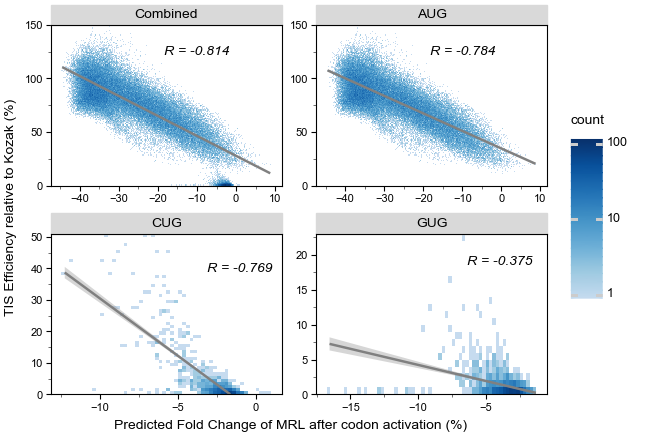

<ggplot: (2986221744448)>

In [11]:
combined_all['codon_cat'] = pd.Categorical(combined_all['codon'], categories=codon_keys)
r_dat['codon_cat'] = pd.Categorical(r_dat['codon'], categories=codon_keys)
r_dat["x_pos"] = [-10, -10, -1, -4]
r_dat["y_pos"] = [125, 125, 40, 19]

# Plot
p = (plotnine.ggplot(combined_all, plotnine.aes('PredFC', 'TIS_Efficiency'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = [0.25,1])
 + plotnine.scale_y_continuous(limits = (0, float("NaN")), expand=(0,0))
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 #+ plotnine.labs(fill="")
 + plotnine.xlab("Predicted Fold Change of MRL after codon activation (%)")
 + plotnine.ylab("TIS Efficiency relative to Kozak (%)")
 #+ plotnine.scale_x_continuous(trans='log10')
 #+ plotnine.annotation_logticks(sides="b")
 + plotnine.stat_smooth(method='lm', color="grey")
 + plotnine.facet_wrap("codon_cat", scales="free")
 + plotnine.geom_text(size = 10, data = r_dat, mapping = plotnine.aes(x = "x_pos", y = "y_pos", label = "r"), fontstyle = "italic")
 + plotnine.theme_matplotlib()
 + plotnine.theme(subplots_adjust={'wspace':0.15, "hspace":0.3}))
 #+ plotnine.theme(legend_direction="horizontal", legend_position = (0.75, 0.80)))
p

In [12]:
p.save("../Graphics/" + "uTIS_50" + ".svg")

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/uTIS_50.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6

### Framepool100

In [13]:
# select which model to use
model_to_apply = utr_model
# prepare run
extra_encoding_fn = []
one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
one_hot_fn_active = utils_data.OneHotEncoder("snv")
samples = 100
diffs = []
# run
for i in range(samples):
    prefix = ''.join(random.choices(["C","T","G"], k=9)) # fast way to get AUG free seq 
    suffix = ''.join(random.choices(["C","T","G"], k=9)) # fast way to get AUG free seq
    noderer_df_aug["snv"] = [prefix + seq + suffix for seq in
                                            noderer_df_aug["TIS_Sequence"]]
    noderer_df_aug["wt"] = [prefix + seq + suffix for seq in
                                        noderer_df_aug["TIS_Sequence_AGG"]]
    gen_wt = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                     shuffle=False)
    predict_wt_only = model_to_apply.predict_generator(gen_wt, verbose=0)
    gen_snv = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                      shuffle=False)
    predict_snv_only = model_to_apply.predict_generator(gen_snv, verbose=0)
    log_pred_diff_only = np.log2(predict_snv_only/predict_wt_only)
    diffs.append(log_pred_diff_only)
    print(i)
diffs = sum(diffs)/len(diffs)
noderer_df_aug["Predicted log2 Fold Change"] = diffs.reshape(-1)
noderer_df_aug["PredFC"] = (2 ** noderer_df_aug["Predicted log2 Fold Change"])*100 - 100
noderer_df_aug["codon"] = "AUG"
noderer_df_aug_reduced = noderer_df_aug[['TIS_Sequence', 'TIS_Efficiency', "PredFC", "codon"]]
print(stats.pearsonr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))
print(stats.spearmanr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))
noderer_df_aug_reduced.to_csv(Path("../Data/Predictions/aug_100_predictions.csv"))

# make random seq without AUG
def random_seq_noaug(exclude_motifs=["CTG","GTG"]):
    seq = ''.join(random.choices(["A","C","T","G"], k=9))
    # (try to) clean out unwanted motifs that could eat results
    for motif in exclude_motifs:
        motifs_present = [m.start() for m in re.finditer(motif, seq)]
        for idx in motifs_present:
            seq = seq[:idx] + ''.join(random.choices(["A","C","T","G"], k=2)) + seq[idx+3:]
    # (surely) clean out atg, since they dominate everything
    atg_present = [m.start() for m in re.finditer('ATG', seq)]
    for idx in atg_present:
        seq = seq[:idx] + "C" + ''.join(random.choices(["C","T","G"], k=2)) + seq[idx+3:]
    return seq
    
# Predict
# Select model and prepare run
extra_encoding_fn = []
model_to_apply = utr_model
nonaug_dict = {key:noderer_df_nonaug[noderer_df_nonaug["TIS_Sequence"].str[-4:-1] == key] for key in
               set(noderer_df_nonaug["TIS_Sequence"].str[-4:-1])}
key_to_inactive = {'CTG':"CTT", 'ACG':"ACT", 'AAG':"AAC", 'GTG':"GTT", 
                   'ATA':"ACT", 'AGG':"AGT", 'ATT':"GTT", 'ATC':"GTC", 
                   'TTG':"TTT"}
one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
one_hot_fn_active = utils_data.OneHotEncoder("snv")
samples = 100
# Run
for key in nonaug_dict.keys():
    nonaug_dict[key]["TIS_inactive"] = [seq[:-4] + key_to_inactive[key] + seq[-1] for seq in
                                        nonaug_dict[key]["TIS_Sequence"]]
    diff_list = []
    for i in range(samples):
        prefix = random_seq_noaug()
        suffix = random_seq_noaug()
        nonaug_dict[key]["snv"] = [prefix + seq + suffix for seq in
                                            nonaug_dict[key]["TIS_Sequence"]]
        nonaug_dict[key]["wt"] = [prefix + seq + suffix for seq in
                                        nonaug_dict[key]["TIS_inactive"]]
        gen_wt = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                         shuffle=False)
        predict_wt_nonaug = model_to_apply.predict_generator(gen_wt, verbose=0)
        gen_snv = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                          shuffle=False)
        predict_snv_nonaug = model_to_apply.predict_generator(gen_snv, verbose=0)
        log_pred_diff_nonaug = np.log2(predict_snv_nonaug/predict_wt_nonaug)
        diff_list.append(log_pred_diff_nonaug)
    print("iteration done")
    diffs = sum(diff_list)/len(diff_list)    
    nonaug_dict[key]["Predicted log2 Fold Change"] = diffs
# Combine
df_list = []
for key in nonaug_dict.keys():
    if key not in ["CTG", "GTG"]:
        continue
    nonaug_dict[key]["codon"] = key.replace("T","U")
    nonaug_dict[key]["PredFC"] = (2 ** nonaug_dict[key]["Predicted log2 Fold Change"])*100 - 100
    df_list.append(nonaug_dict[key][['TIS_Sequence', 'TIS_Efficiency', "PredFC", "codon"]])
combined_nonaug = pd.concat(df_list)
# Save
combined_nonaug.to_csv(Path("../Data/Predictions/nonaug_100_predictions.csv"))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
(-0.763912826616041, 0.0)
SpearmanrResult(correlation=-0.7550596102908669, pvalue=0.0)
iteration done
iteration done
iteration done
iteration done
iteration done
iteration done
iteration done
iteration done
iteration done


In [14]:
# Read AUG data
noderer_df_aug_reduced = pd.read_csv(Path("../Data/Predictions/aug_100_predictions.csv"))
# Read Non aug data
combined_nonaug = pd.read_csv(Path("../Data/Predictions/nonaug_100_predictions.csv"))

# combine
combined_codon_df = pd.concat([noderer_df_aug_reduced, combined_nonaug])
# copy
all_df = combined_codon_df.copy()
allname = "Combined"
all_df["codon"] = allname
# combine with copy
combined_all = pd.concat([all_df, combined_codon_df[combined_codon_df.codon.isin(["AUG", "CUG", "GUG"])]])


# compute correlations
codon_keys = [allname, "AUG", "CUG", "GUG"]
r_list = []
for key in codon_keys:
    subcodon_df = combined_all[combined_all.codon == key]
    r = "R = " + str(round(stats.pearsonr(subcodon_df["TIS_Efficiency"], subcodon_df["PredFC"])[0], 3))
    r_list.append(r)
r_dat = pd.DataFrame({"codon":codon_keys,"r":r_list})
r_dat

,codon,r
0,Combined,R = -0.806
1,AUG,R = -0.779
2,CUG,R = -0.425
3,GUG,R = -0.009


/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  r

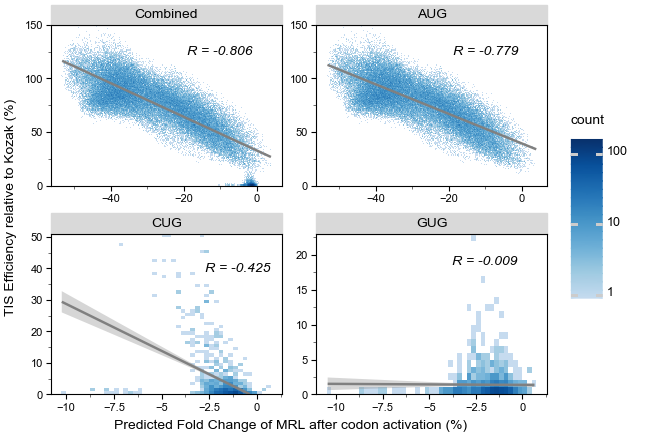

<ggplot: (2986303253873)>

In [17]:
combined_all['codon_cat'] = pd.Categorical(combined_all['codon'], categories=codon_keys)
r_dat['codon_cat'] = pd.Categorical(r_dat['codon'], categories=codon_keys)
r_dat["x_pos"] = [-10, -10, -1, -2]
r_dat["y_pos"] = [125, 125, 40, 19]

# Plot
p = (plotnine.ggplot(combined_all, plotnine.aes('PredFC', 'TIS_Efficiency'))
     #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
     + plotnine.geom_bin2d(binwidth = [0.25,1])
     + plotnine.scale_y_continuous(limits = (0, float("NaN")), expand=(0,0))
     + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
     #+ plotnine.labs(fill="")
     + plotnine.xlab("Predicted Fold Change of MRL after codon activation (%)")
     + plotnine.ylab("TIS Efficiency relative to Kozak (%)")
     #+ plotnine.scale_x_continuous(trans='log10')
     #+ plotnine.annotation_logticks(sides="b")
     + plotnine.stat_smooth(method='lm', color="grey")
     + plotnine.facet_wrap("codon_cat", scales="free")
     + plotnine.geom_text(size = 10, data = r_dat, mapping = plotnine.aes(x = "x_pos", y = "y_pos", label = "r"), fontstyle = "italic")
     + plotnine.theme_matplotlib()
     + plotnine.theme(subplots_adjust={'wspace':0.15, "hspace":0.3}))
     #+ plotnine.theme(legend_direction="horizontal", legend_position = (0.75, 0.80)))
p

In [18]:
p.save("../Graphics/" + "uTIS_100" + ".svg")

/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/uTIS_100.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.